In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from enum import Enum
from time import time
from pathlib import Path

# Third-Party Library Imports
import numpy as np
import xarray as xr
import dask
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import my_stats
import toe_calc
import open_data
import toe_constants as toe_const
import toe_data_analysis
from toe_calc_variations import fga, ks, sn_ratio
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")
warnings.filterwarnings("ignore")

Matplotlib created a temporary cache directory at /jobfs/139590882.gadi-pbs/matplotlib-zfjco9ik because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
%config Application.verbose_crash=True

In [3]:
xr.set_options(display_expand_data=False)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [5]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [6]:
# client.close()

In [7]:
from dask.distributed import Client, wait
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=80, threads_per_worker=1, memory_limit=None) 
client

 - State start
 - Found stale lock file and directory '/jobfs/139590882.gadi-pbs/dask-scratch-space/scheduler-wrbexwtd', purging
 -   Scheduler at:     tcp://127.0.0.1:42187
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:39709'
 -         Start Nanny at: 'tcp://127.0.0.1:33763'
 -         Start Nanny at: 'tcp://127.0.0.1:34143'
 -         Start Nanny at: 'tcp://127.0.0.1:37621'
 -         Start Nanny at: 'tcp://127.0.0.1:43859'
 -         Start Nanny at: 'tcp://127.0.0.1:33569'
 -         Start Nanny at: 'tcp://127.0.0.1:41109'
 -         Start Nanny at: 'tcp://127.0.0.1:40567'
 -         Start Nanny at: 'tcp://127.0.0.1:46687'
 -         Start Nanny at: 'tcp://127.0.0.1:45837'
 -         Start Nanny at: 'tcp://127.0.0.1:45613'
 -         Start Nanny at: 'tcp://127.0.0.1:41333'
 -         Start Nanny at: 'tcp://127.0.0.1:45025'
 -         Start Nanny at: 'tcp://127.0.0.1:44975'
 -         Start Nanny at: 't

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 80
Total threads: 80,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42187,Workers: 80
Dashboard: /proxy/8787/status,Total threads: 80
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38953,Total threads: 1
Dashboard: /proxy/46781/status,Memory: 0 B
Nanny: tcp://127.0.0.1:39709,


 - full garbage collection released 28.31 MiB from 114 reference cycles (threshold: 9.54 MiB)
 - full garbage collection released 120.61 MiB from 8392 reference cycles (threshold: 9.54 MiB)
 - full garbage collection released 10.55 MiB from 5951 reference cycles (threshold: 9.54 MiB)


In [8]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

In [9]:
np.sort(os.listdir(constants.TOE_SAVE_DIR))

array(['.ipynb_checkpoints', 'access_ssp585_pr_(1880_1909)',
       'access_ssp585_pr_multi_base_period.zarr',
       'access_ssp585_pr_region_aggregation.zarr',
       'access_ssp585_pr_region_aggregationv2.zarr',
       'access_ssp585_tas_(1880_1909)',
       'access_ssp585_tas_multi_base_period.zarr',
       'access_ssp585_tas_multi_base_period_v2.zarr',
       'access_ssp585_tas_multi_base_period_v3.zarr',
       'access_ssp585_tas_multi_base_period_v4.zarr',
       'access_ssp585_tas_multi_base_period_v5_tmp.zarr',
       'access_ssp585_tas_region_aggregation.zarr',
       'best_tas_(1880_1910)', 'best_tas_(1890_1920)',
       'best_tas_(1900_1930)', 'best_tas_(1910_1940)',
       'best_tas_(1920_1950)', 'best_tas_(1920_1950)_16p0x16p0',
       'best_tas_(1920_1950)_2p0x2p0', 'best_tas_(1920_1950)_32p0x32p0',
       'best_tas_(1920_1950)_4p0x4p0', 'best_tas_(1920_1950)_8p0x8p0',
       'best_tas_(1930_1960)', 'best_tas_(1940_1970)',
       'best_tas_multi_base_period.zarr',
      

In [10]:
# variable = 'tas'
# model  =  'best'
# dataset_name  = model

# experiment = 'rcp85'
# model = 'cesm1_lens'

variable = 'pr'
experiment = 'ssp585'
model = 'access'
# dataset_name = f'{model}_{experiment}_{variable}'

In [11]:
test_name = 'multi_base_period'
# test_name = 'regrid_conservative'
# test_name = 'region_aggregation'

In [12]:
dataset_name = f'{model}_{experiment}_{variable}_{test_name}'

In [13]:
SAVE_NAME = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}.zarr')
SAVE_NAME                         

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_multi_base_period.zarr'

In [14]:
# chunks_best_small = {'time':-1, 'lat': 180//10, 'lon': 360//10}
# LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//6, 'lat':72//12}
# LE_CESM_CHUNKS = {'member': -1, 'time':-1, 'lon':144//8, 'lat':72//12}
ACCESS_CHUNKS = {'time':-1, 'member':1, 'lat': 72, 'lon':144//2} # 80 chunks
# ACCESS_CHUNKS = {'time':-1, 'member':1, 'lat': 72//2, 'lon':144//2} # 160 chunks
# ACCESS_CHUNKS = {'time':-1, 'member':1, 'lat': 72//2, 'lon':144//3} # 240 chunks

# ACCESS_CHUNKS = {'time':-1, 'member':1, 'lat': 72//3, 'lon':144//3} # 360 chunks

chunks = ACCESS_CHUNKS#ACCESS_CHUNKS#chunks_best_small#LE_CESM_CHUNKS

In [15]:
# If no ensemble
# plot_kwargs = {} 
# ensemble_kwargs = {}

# If ensemble
plot_kwargs = {'hue':'member', 'add_legend':False} 
ensemble_kwargs = {'member': 0}

In [16]:
# data_raw_ds = open_data.open_best(chunks).persist()
# wait(data_raw_ds);

In [17]:
FILE_NAME = f'/g/data/w40/ab2313/time_of_emergence/{model}_{experiment}_{variable}.zarr'
FILE_NAME

'/g/data/w40/ab2313/time_of_emergence/access_ssp585_pr.zarr'

In [18]:
data_raw_ds = xr.open_dataset(FILE_NAME, engine='zarr', chunks=chunks)[variable]

In [19]:
data_raw_ds

<xarray.DataArray 'pr' (member: 40, time: 251, lat: 72, lon: 144)> Size: 833MB
dask.array<open_dataset-pr, shape=(40, 251, 72, 144), dtype=float64, chunksize=(1, 251, 72, 72), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes: (1)

In [20]:
# Tranpose time to be last dimension to make transpose easier 
data_raw_ds = data_raw_ds.transpose(..., "time").persist()
wait(data_raw_ds);

In [21]:
data_raw_ds.chunks

((1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1),
 (72,),
 (72, 72),
 (251,))

In [22]:
# data_raw_ds = data_raw_ds.isel(member=slice(0,3))

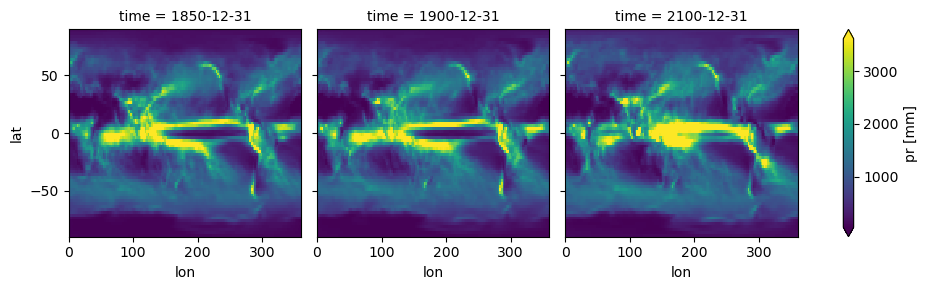

In [23]:
data_raw_ds.isel(time=[0, 50, -1]).isel(**ensemble_kwargs).plot(col='time', robust=True)

In [24]:
data_raw_ds

<xarray.DataArray 'pr' (member: 40, lat: 72, lon: 144, time: 251)> Size: 833MB
dask.array<transpose, shape=(40, 72, 144, 251), dtype=float64, chunksize=(1, 72, 72, 251), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1850-12-31 1851-12-31 ... 2100-12-31
Attributes: (1)

In [25]:
window = 30
CHUNKS_FOR_PVALUE_TESTS = chunks

<h1 style='color:yellow'> Spatial Aggregation </h1>

In [29]:
lsm_dict = {
    'best_tas': '/g/data/w40/ab2313/time_of_emergence/best/best_mask.zarr',
    'access_ssp585_tas': '/g/data/w40/ab2313/time_of_emergence/access_lsm.zarr'
    # 'access_ssp585_tas': '/g/data/w40/ab2313/time_of_emergence/access_mask.zarr'
}

In [30]:
lsm_ds = xr.open_dataarray(lsm_dict['access_ssp585_tas']).compute()
lsm_ds

<xarray.DataArray 'mask' (lat: 72, lon: 144)> Size: 83kB
array([[1, ..., 1],
       ...,
       [0, ..., 0]])
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8

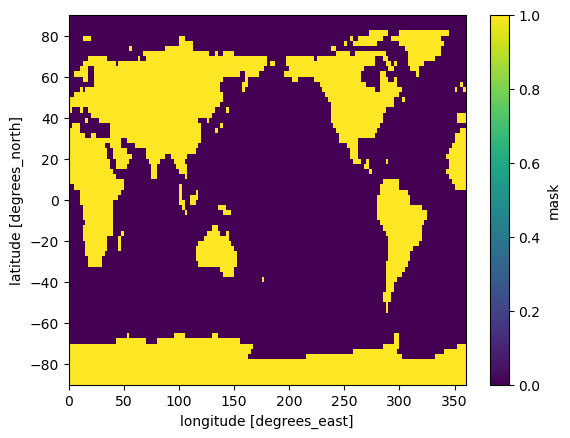

In [31]:
lsm_ds.plot()

In [32]:
regions = toe_const.regionLatLonTuples

In [33]:
weights_da = toe_data_analysis.compute_weights(data_raw_ds)
weights_da

<xarray.DataArray 'weights' (lat: 72)> Size: 576B
array([0.02, 0.07, 0.11, 0.15, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44,
       0.48, 0.52, 0.56, 0.59, 0.63, 0.66, 0.69, 0.72, 0.75, 0.78, 0.81,
       0.83, 0.85, 0.88, 0.9 , 0.92, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99,
       0.99, 1.  , 1.  , 1.  , 1.  , 0.99, 0.99, 0.98, 0.97, 0.96, 0.95,
       0.93, 0.92, 0.9 , 0.88, 0.85, 0.83, 0.81, 0.78, 0.75, 0.72, 0.69,
       0.66, 0.63, 0.59, 0.56, 0.52, 0.48, 0.44, 0.4 , 0.36, 0.32, 0.28,
       0.24, 0.2 , 0.15, 0.11, 0.07, 0.02])
Coordinates:
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Attributes: (4)

In [34]:
region_store = []
for region in list(regions):
    region_name = region.value.name
    lat_slice = region.value.latlon

    ds_region = data_raw_ds.sel(lat=lat_slice).expand_dims({'region': [region_name]})

    if region_name in ['land', 'ocean']:
        mask_to_use_ds = lsm_ds if region_name == 'land' else xr.where(lsm_ds, 0, 1)

        ds_region = ds_region.where(mask_to_use_ds)
    region_store.append(ds_region)

In [35]:
all_region_ds = xr.concat(region_store, dim='region').compute()

In [36]:
region_mean_ds = all_region_ds.weighted(weights_da).mean(dim=['lat', 'lon']).compute()
region_mean_ds = region_mean_ds.sel(time=slice('1880', None))

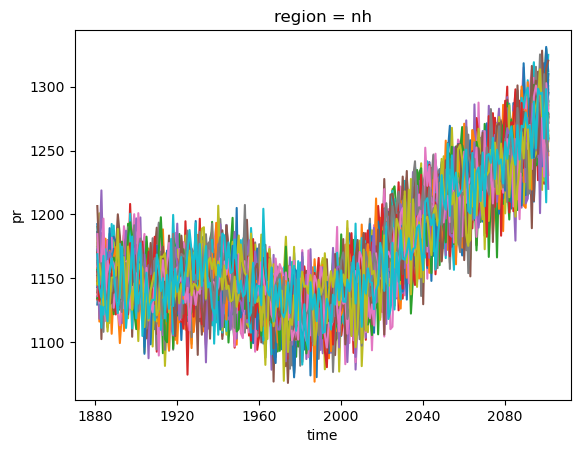

In [37]:
region_mean_ds.isel(region=3).plot(hue='member', add_legend=False);

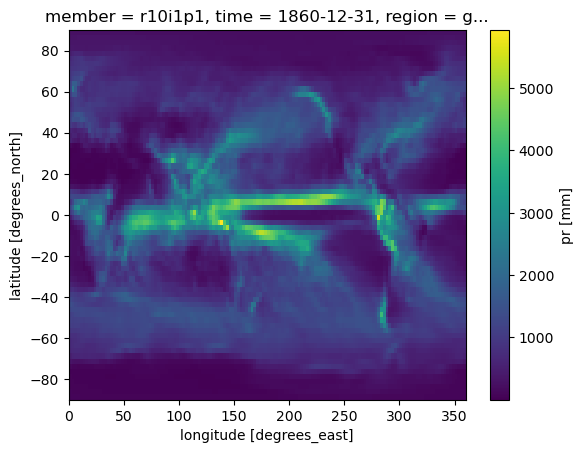

In [38]:
all_region_ds.isel(region=0).isel(member=0, time=10).plot()

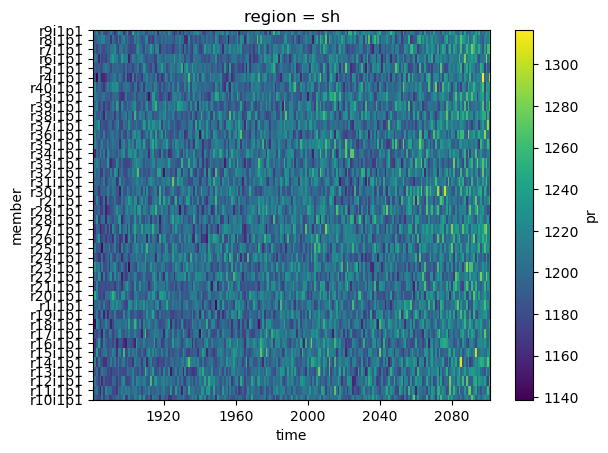

In [39]:
# region_store[4].weighted(weights).mean(dim=['lat', 'lon']).plot()
region_mean_ds.sel(region='sh').plot()

In [41]:
region_mean_ds

<xarray.DataArray 'pr' (region: 10, member: 40, time: 221)> Size: 707kB
array([[[1174.12, ..., 1246.62],
        ...,
        [1171.59, ..., 1257.77]],

       ...,

       [[ 393.96, ...,  531.62],
        ...,
        [ 386.94, ...,  522.82]]])
Coordinates:
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
  * region   (region) object 80B 'global' 'land' ... 'arctic' 'antarctic'

In [44]:
import toe_calc_variations

In [46]:
reload(toe_calc_variations)

<module 'toe_calc_variations' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc_variations.py'>

In [47]:
sn_region_ds = toe_calc_variations.sn_ratio(region_mean_ds).compute()

In [48]:
sn_region_ds

<xarray.Dataset> Size: 4MB
Dimensions:         (member: 40, time: 221, region: 10)
Coordinates:
  * member          (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time            (time) datetime64[ns] 2kB 1880-12-31 ... 2100-12-31
  * region          (region) object 80B 'global' 'land' ... 'arctic' 'antarctic'
Data variables:
    sn              (region, member, time) float64 707kB 0.05702 ... 15.0
    sn_lowess_full  (region, member, time) float64 707kB 0.05984 0.068 ... 13.3
    sn_roll         (region, member, time) float64 707kB nan nan nan ... nan nan
    noise           (region, member, time) float64 707kB 2.353 1.55 ... -14.87
    signal          (region, member, time) float64 707kB 0.2141 0.2433 ... 136.7

In [49]:
window = 30

data_ds_window = (
    region_mean_ds
    .rolling(time=window, center=True, min_periods=window)
    .construct('window_dim')
    .transpose(..., 'time') # Window dim is last, so make sure time is last
    .persist()
) 

base_period_window_ds = (
    region_mean_ds.sel(time=slice('1880', '1909'))
    .rename({'time':'window_dim'})
    .persist()
)

In [50]:
ks_ds = ks(data_ds_window, base_period_window_ds).compute()

In [51]:
fga_ds = fga(region_mean_ds.chunk('auto'),
             region_mean_ds.sel(time=slice('1880', '1909')).chunk('auto'),
             data_ds_window).compute()

In [52]:
ks_ds

<xarray.DataArray 'ks' (region: 10, member: 40, time: 221)> Size: 707kB
array([[[0.99, ..., 0.  ],
        ...,
        [0.46, ..., 0.  ]],

       ...,

       [[0.99, ..., 0.  ],
        ...,
        [0.94, ..., 0.  ]]])
Coordinates:
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1880-12-31 1881-12-31 ... 2100-12-31
  * region   (region) object 80B 'global' 'land' ... 'arctic' 'antarctic'

In [64]:
region_metric_ds = xr.merge(
    [ks_ds, fga_ds, sn_region_ds[['sn', 'sn_lowess_full', 'noise', 'signal']], region_mean_ds])

In [65]:
region_metric_ds

<xarray.Dataset> Size: 5MB
Dimensions:         (member: 40, time: 221, region: 10)
Coordinates:
  * member          (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time            (time) datetime64[ns] 2kB 1880-12-31 ... 2100-12-31
  * region          (region) object 80B 'global' 'land' ... 'arctic' 'antarctic'
Data variables:
    ks              (region, member, time) float64 707kB 0.9935 ... 2.017e-12
    frac            (region, member, time) float64 707kB 84.54 ... 4.909e-26
    sn              (region, member, time) float64 707kB 0.05702 ... 15.0
    sn_lowess_full  (region, member, time) float64 707kB 0.05984 0.068 ... 13.3
    noise           (region, member, time) float64 707kB 2.353 1.55 ... -14.87
    signal          (region, member, time) float64 707kB 0.2141 0.2433 ... 136.7
    pr              (region, member, time) float64 707kB 1.174e+03 ... 522.8

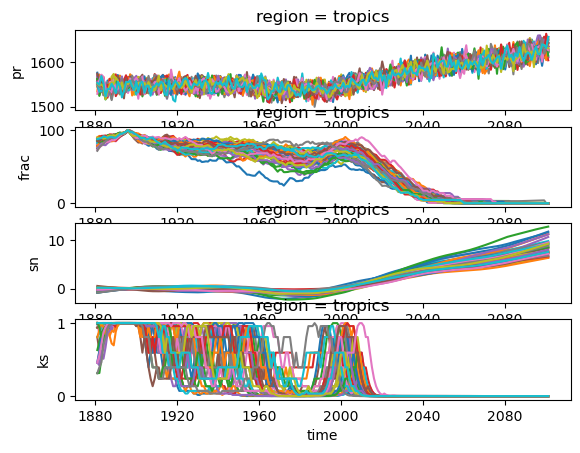

In [67]:
fig ,(ax0, ax1, ax2, ax3) = plt.subplots(4, 1)
region_metric_ds['pr'].sel(region='tropics').plot(ax=ax0, hue='member', add_legend=False);
region_metric_ds['frac'].sel(region='tropics').plot(ax=ax1, hue='member', add_legend=False);
region_metric_ds['sn'].sel(region='tropics').plot(ax=ax2, hue='member', add_legend=False);
region_metric_ds['ks'].sel(region='tropics').plot(ax=ax3,hue='member', add_legend=False);

In [71]:
SAVE_NAME = SAVE_NAME.replace('.zarr', 'v2.zarr')

In [72]:
SAVE_NAME

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_pr_region_aggregationv2.zarr'

In [73]:
region_metric_ds.to_zarr(SAVE_NAME)

In [74]:
toe_ks_region_ds = toe_calc.get_permanent_exceedance(ks_ds, 0.01, np.less)

In [75]:
toe_fga_region_ds = toe_calc.get_permanent_exceedance(fga_ds, 62, np.less)

In [76]:
toe_ks_region_ds.isel(region=5).median()

<xarray.DataArray 'ks' ()> Size: 8B
array(2011.5)
Coordinates:
    region   <U7 28B 'tropics'

In [82]:
toe_ks_region_ds.to_pandas().median(axis=1)

region
global        2010.0
land          2050.0
ocean         2009.5
nh            2022.5
sh            2076.5
tropics       2011.5
mid_lat_sh    2048.5
mid_lat_nh    2027.0
arctic        2001.5
antarctic     1984.0
dtype: float64

2025-03-20 14:48:33,631 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


In [81]:
toe_fga_region_ds.to_pandas().median(axis=1)

region
global        2005.5
land          2050.0
ocean         2008.0
nh            2022.0
sh            2080.5
tropics       2011.5
mid_lat_sh    2048.0
mid_lat_nh    2026.5
arctic        2002.0
antarctic     1984.0
dtype: float64

In [210]:
toe_sn_region_ds.sn.to_pandas()

region
global        1925.0
land          1919.0
ocean         1929.0
nh            1923.0
sh            1932.0
tropics       1931.0
mid_lat_sh    1936.0
mid_lat_nh    1922.0
arctic        1980.0
antarctic     1997.0
dtype: float64

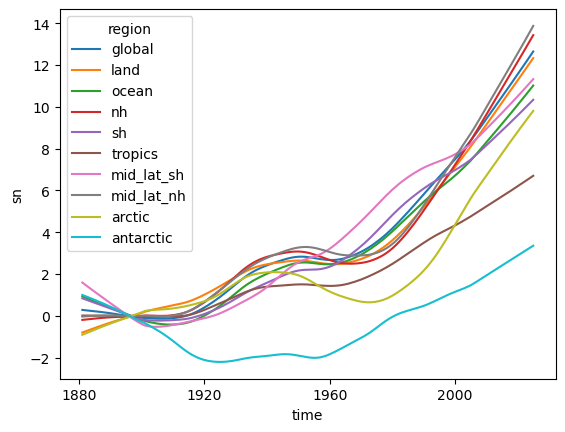

In [171]:
sn_region_ds.sn.plot(hue='region');

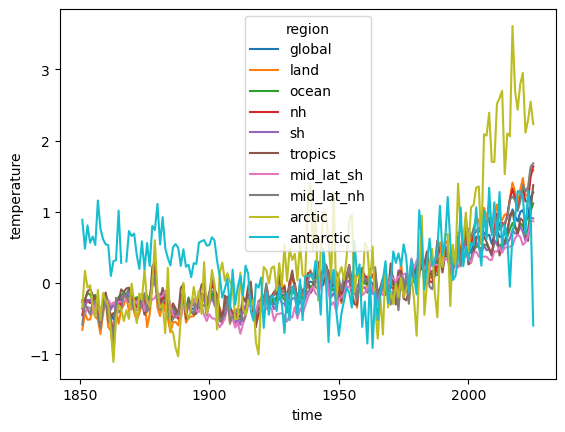

In [160]:
region_mean_ds.plot(hue='region', add_legend=True);

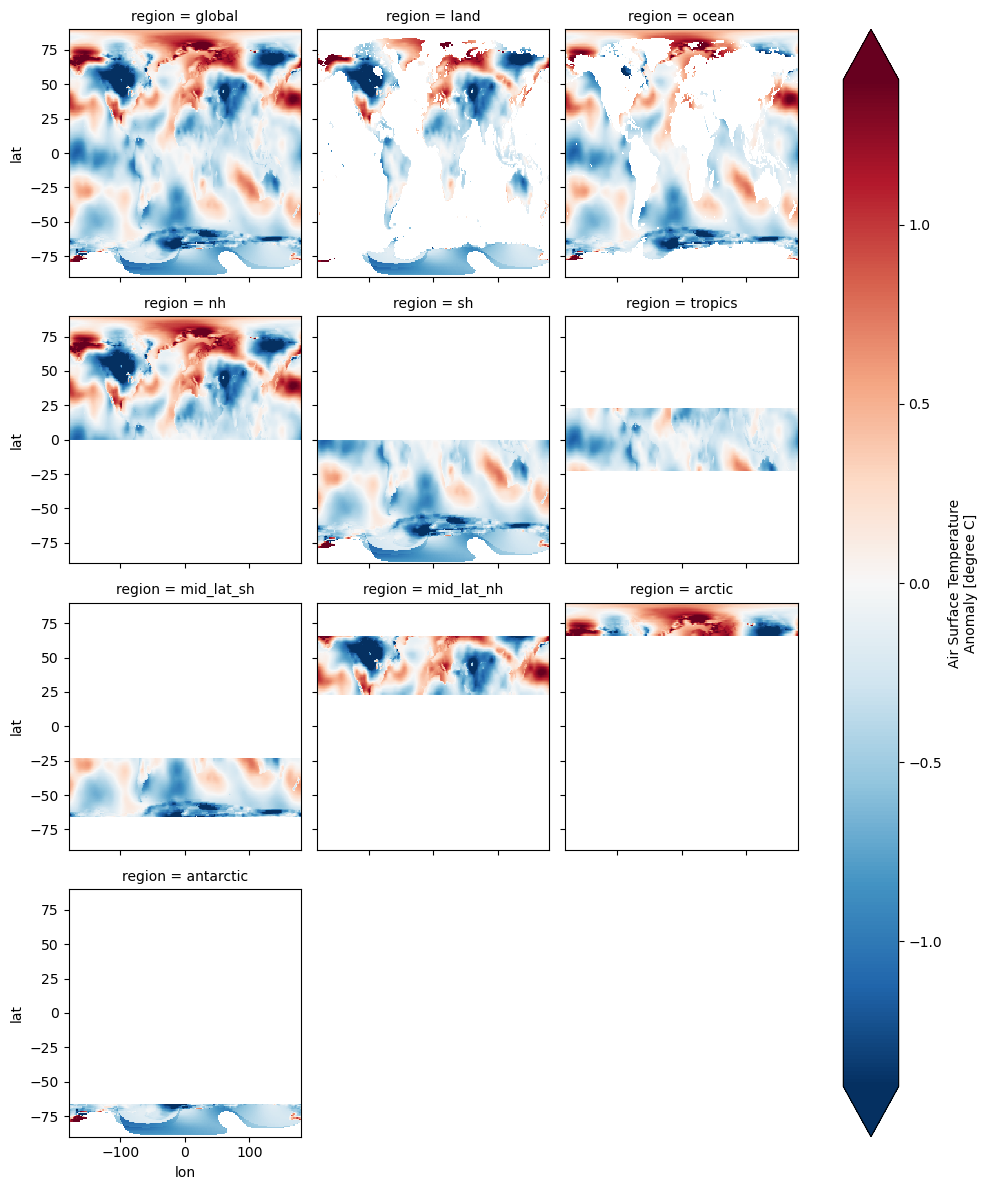

In [139]:
all_region_ds.isel(time=100).plot(col='region', col_wrap=3, robust=True)

<h1 style='color:cyan'>  Resolution </h1>

In [31]:
import xesmf

In [52]:
def get_resolution_name(lat, lon, ts):
    lat_res = np.unique(np.diff(lat[ts]))[0]
    lon_res = np.unique(np.diff(lon[ts]))[0]
    return f'{lat_res}x{lon_res}'.replace('.', 'p')

In [28]:
window = 30
CHUNKS_FOR_PVALUE_TESTS = chunks

In [71]:
# They are different resolution so cannot be merged together (will need data tree later)
SAVE_NAME = SAVE_NAME.replace('.zarr', '')
SAVE_NAME

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_tas_regrid_conservative'

In [72]:
os.makedirs(SAVE_NAME, exist_ok=True)

In [73]:
os.listdir(SAVE_NAME)

['2p0x2p0.zarr']

In [101]:
target_slices = (slice(None, None, None), slice(None, None, 2), slice(None, None, 4),
                 slice(None, None, 8), slice(None, None, 16), slice(None, None, 32))

In [75]:
get_resolution_name(data_raw_ds.lat.values, data_raw_ds.lon.values, target_slices[3])

'16p0x16p0'

In [47]:
data_raw_ds = data_raw_ds.sel(time=slice('1880', None))

In [48]:
data_raw_ds

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 145)> Size: 38MB
dask.array<getitem, shape=(180, 360, 145), dtype=float32, chunksize=(18, 36, 145), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1880-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (6)

In [102]:
for i, ts in enumerate(target_slices[:1]):
    t_start = time()
    print(f'{ts}, ', end='')

    # Re-grid dataset
    ds_out = xr.Dataset(
        {
            "lat": (["lat"], data_raw_ds.lat.values[ts]),  # Every other latitude
            "lon": (["lon"], data_raw_ds.lon.values[ts])  # Every other longitude
        }
    )
    
    regridder = xesmf.Regridder(data_raw_ds, ds_out, method="conservative") 
    data_ds = regridder(data_raw_ds).persist()
    wait(data_ds);

    # Create base period
    base_period_ds = data_ds.sel(time=slice('1880', '1909'))

    # Create data availability mask
    base_period_ds_count = base_period_ds.count(dim='time')
    percent_80_of_years = 0.8*30
    data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
    
    data_ds = data_ds.where(data_availability_mask)
    base_period_ds = base_period_ds.where(data_availability_mask)

    # Construct windowed datasets
    data_ds_window = (
        data_ds
        .rolling(time=window, center=True, min_periods=window)
        .construct('window_dim')
        .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
        .transpose(..., 'time') # Window dim is last, so make sure time is last
        .persist()
    ) 
    
    base_period_window_ds = (
        base_period_ds
        .chunk(CHUNKS_FOR_PVALUE_TESTS)
        .rename({'time':'window_dim'})
        .persist()
    )

    wait(data_ds_window);
    wait(base_period_window_ds);
    
    sn_ds = sn_ratio(data_ds, start=0, end=30)
    print('.', end='')
    ks_ds = ks(data_ds_window, base_period_window_ds)
    print('.', end='')
    fga_ds = fga(data_ds, base_period_ds, data_ds_window)
    print('.', end='')
    
    out_ds = xr.merge([sn_ds, ks_ds, fga_ds])

    res_name = get_resolution_name(data_raw_ds.lat.values, data_raw_ds.lon.values, ts)
    print(f'{res_name=}')
    
    out_ds = out_ds.expand_dims('resolution').assign_coords(
        resolution=[res_name])

    OUTFILE_NAME = os.path.join(SAVE_NAME, f'{res_name}.zarr')
    print(f'Saving file - {OUTFILE_NAME}')

    out_ds.to_zarr(OUTFILE_NAME, mode='w',)
        
    time_taken = (time() - t_start)/60
    print(f' ({time_taken:.2f})')

slice(None, None, None), .

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


..res_name='1p0x1p0'
Saving file - /g/data/w40/ab2313/time_of_emergence/toe_metrics/best_tas_regrid_conservative/1p0x1p0.zarr
 (2.95)


In [90]:
test_res_ds = xr.open_dataset(OUTFILE_NAME.replace('32', '4'), engine='zarr')
test_res_2_ds = xr.open_dataset(OUTFILE_NAME.replace('32', '2'), engine='zarr')

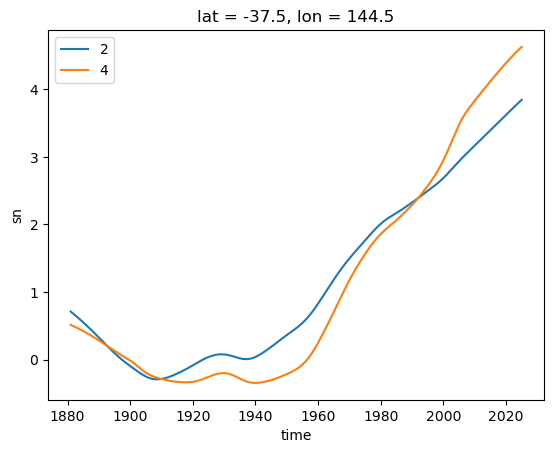

In [100]:
test_res_2_ds.sel(lat=-39, lon=145, method='nearest').sn.plot(label='2')
test_res_ds.sel(lat=-39, lon=145, method='nearest').sn.plot(label='4')
plt.legend()

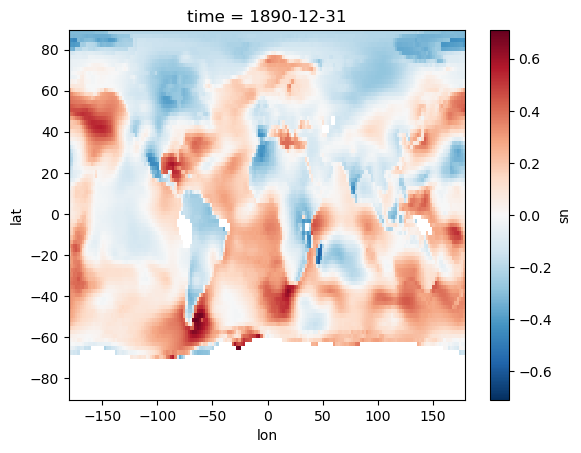

In [92]:
test_res_2_ds.sn.isel(time=10).plot()

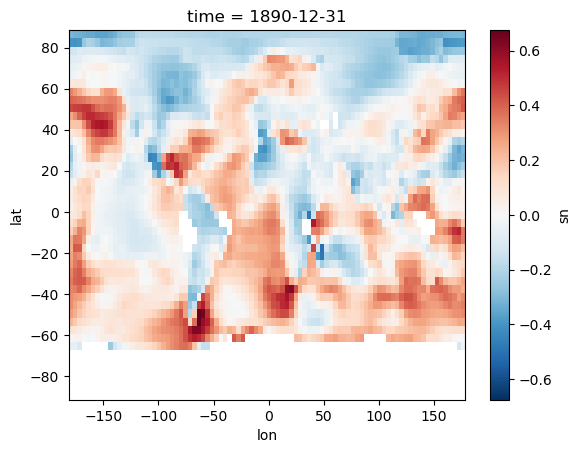

In [93]:
test_res_ds.sn.isel(time=10).plot()

<h1 style='color:cyan'>  Multi Base Period </h1>

In [26]:
SAVE_NAME

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_multi_base_period.zarr'

In [27]:
# Check if file already exists
# If it does, check what base_period is has already been saved with
if Path(SAVE_NAME).exists():
    print(f'File already exists - {SAVE_NAME}')
    with xr.open_zarr(SAVE_NAME) as ds:
        save_based_periods = np.array(ds.base_period.values)
else:
    print(f'File does not exist yet - {SAVE_NAME}')
    save_based_periods = []#['-9999'] # Default fill to stop erros

File already exists - /g/data/w40/ab2313/time_of_emergence/toe_metrics/access_ssp585_pr_multi_base_period.zarr


In [28]:
save_based_periods_start = np.array(list(map(lambda x: int(x.split('_')[0]), save_based_periods)))
save_based_periods_start

array([1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900,
       1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950])

In [29]:
base_period_starts = np.sort(list(map(lambda x: int(x.split('_')[0]), save_based_periods)))
base_period_starts

array([1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900,
       1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950])

In [30]:
# all_base_periods = np.arange(1920, 2055, 5)
all_base_periods = np.arange(1850, 2050, 5)
all_base_periods

array([1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895, 1900,
       1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955,
       1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010,
       2015, 2020, 2025, 2030, 2035, 2040, 2045])

In [31]:
base_periods_to_run = np.array([bp for bp in all_base_periods if bp not in save_based_periods_start])
base_periods_to_run

array([1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005,
       2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045])

In [32]:
# base_periods_to_run = all_base_periods[all_base_periods>largest_base_period]
# base_periods_to_run

In [33]:
base_periods_to_run.shape

(19,)

In [34]:
# data_raw_ds = data_raw_ds.chunk({'member':1, 'time':-1, 'lon':-1, 'lat':-1}).tranpose(..., 'time').persist()
# wait(data_raw_ds);

In [35]:
window = 30

In [ ]:
for i, base_period_start in enumerate(base_periods_to_run):
    t_start = time()
    print(f'{base_period_start}, ', end='')
    
    data_ds = data_raw_ds.copy()
    data_ds = data_ds.sel(time=data_ds.time.dt.year>base_period_start)
    
    base_period_obj = toe_const.BasePeriod(base_period_start, base_period_start+29)
    
    base_period_ds = data_ds.sel(
        time=slice(str(base_period_obj.start), str(base_period_obj.end)))

    
    base_period_ds_count = base_period_ds.count(dim='time')
    percent_80_of_years = 0.8*(base_period_obj.end - base_period_obj.start)

    data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
    
    data_ds = data_ds.where(data_availability_mask)
    base_period_ds = base_period_ds.where(data_availability_mask)
    
    data_ds_window = (
        data_ds
        .rolling(time=window, center=True, min_periods=window)
        .construct('window_dim')
        .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
        .transpose(..., 'time') # Window dim is last, so make sure time is last
        .persist()
    ) 
    
    base_period_window_ds = (
        data_ds.sel(time=slice(str(base_period_obj.start), str(base_period_obj.end-1)))
        .chunk(CHUNKS_FOR_PVALUE_TESTS)
        .rename({'time':'window_dim'})
        .persist()
    )

    wait(data_ds_window);
    wait(base_period_window_ds);
    
    sn_ds = sn_ratio(data_ds, start=0, end=30)
    # sn_ratio(data_ds, base_period_ds, base_period_obj)
    print('.', end='')
    ks_ds = ks(data_ds_window, base_period_window_ds)
    print('.', end='')
    fga_ds = fga(data_ds, base_period_ds, data_ds_window)
    print('.', end='')

    out_ds = xr.merge([sn_ds, ks_ds, fga_ds])
    out_ds = out_ds.expand_dims('base_period').assign_coords(
        base_period=[f'{base_period_obj.start}_{base_period_obj.end}'])
    # Length of time needs to match - pad with nans
    out_ds = out_ds.reindex(time=data_raw_ds.time, fill_value=np.nan)

    if not Path(SAVE_NAME).exists():
        print(' - cretaing new file - ', end='')
        out_ds.to_zarr(SAVE_NAME, mode='w')
    else:
        print(f' - appending {base_period_obj.start}_{base_period_obj.end} to baese_period dim - ', end='')
        out_ds.to_zarr(SAVE_NAME, mode='a', append_dim='base_period')
        
    time_taken = (time() - t_start)/60
    print(f' ({time_taken:.2f})')

1955, ... - appending 1955_1984 to baese_period dim -  (17.50)
1960, .. - full garbage collection released 27.62 MiB from 57 reference cycles (threshold: 9.54 MiB)
. - appending 1960_1989 to baese_period dim -  (10.95)
1965,  - full garbage collection released 27.66 MiB from 309 reference cycles (threshold: 9.54 MiB)
... - appending 1965_1994 to baese_period dim -  (10.58)
1970, ... - appending 1970_1999 to baese_period dim -  (10.29)
1975, ... - appending 1975_2004 to baese_period dim -  (9.97)
1980, ... - appending 1980_2009 to baese_period dim -  (9.61)
1985, ... - appending 1985_2014 to baese_period dim -  (9.22)
1990, ... - appending 1990_2019 to baese_period dim -  (8.86)
1995, ... - appending 1995_2024 to baese_period dim -  (8.55)
2000, ... - appending 2000_2029 to baese_period dim -  (8.10)
2005, ... - appending 2005_2034 to baese_period dim -  (7.82)
2010, ... - appending 2010_2039 to baese_period dim -  (7.41)
2015, ... - appending 2015_2044 to baese_period dim -  (7.06)
202

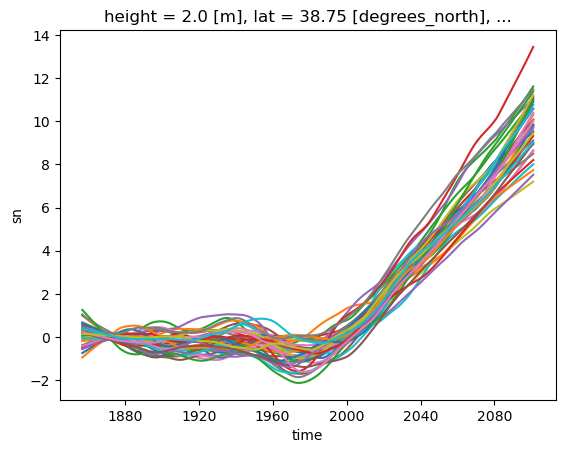

In [62]:
sn_ds.sn.sel(lat=39, lon=145, method='nearest').plot(hue='member', add_legend=False);

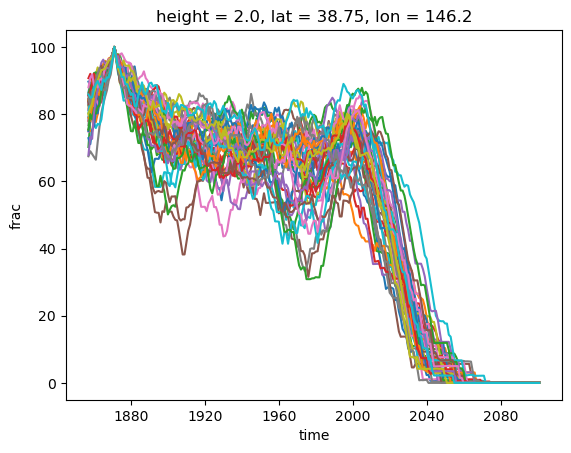

In [55]:
fga_ds.sel(lat=39, lon=145, method='nearest').plot(hue='member', add_legend=False);

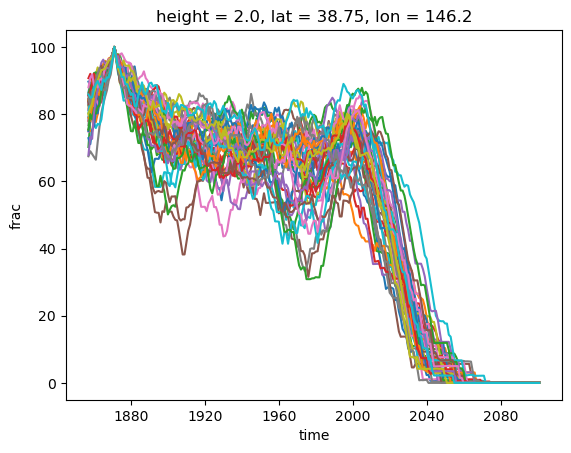

In [56]:
fga_ds.sel(lat=39, lon=145, method='nearest').plot(hue='member', add_legend=False);

In [57]:
base_period_window_ds

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, window_dim: 28)> Size: 93MB
dask.array<getitem, shape=(40, 72, 144, 28), dtype=float64, chunksize=(1, 72, 72, 28), chunktype=numpy.ndarray>
Coordinates:
    height      float64 8B 2.0
  * lat         (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon         (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * member      (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * window_dim  (window_dim) datetime64[ns] 224B 1856-12-31 ... 1883-12-31
Attributes: (7)

In [58]:
data_ds_window

<xarray.DataArray 'tas' (member: 40, lat: 72, lon: 144, window_dim: 30,
                         time: 245)> Size: 24GB
dask.array<transpose, shape=(40, 72, 144, 30, 245), dtype=float64, chunksize=(1, 72, 72, 30, 245), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B 2.0
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member   (member) <U7 1kB 'r10i1p1' 'r11i1p1' ... 'r8i1p1' 'r9i1p1'
  * time     (time) datetime64[ns] 2kB 1856-12-31 1857-12-31 ... 2100-12-31
Dimensions without coordinates: window_dim
Attributes: (7)

In [49]:
test_output = xr.open_dataset(SAVE_NAME, engine='zarr')

In [50]:
# test_output.to_zarr(SAVE_NAME.replace('v4', 'v5_tmp'), mode='w')

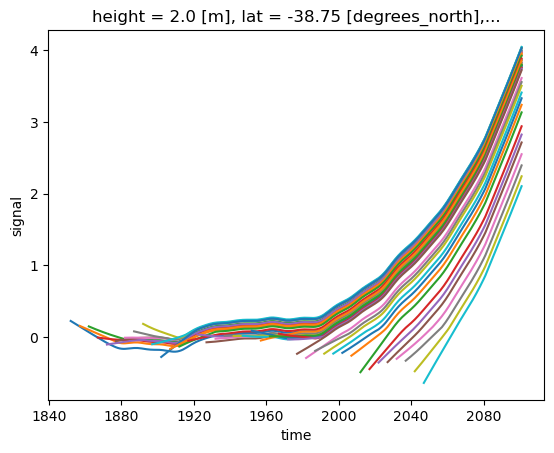

In [51]:
test_output.signal.isel(member=0).sel(lat=-39, lon=145, method='nearest').plot(
    hue='base_period', add_legend=False);

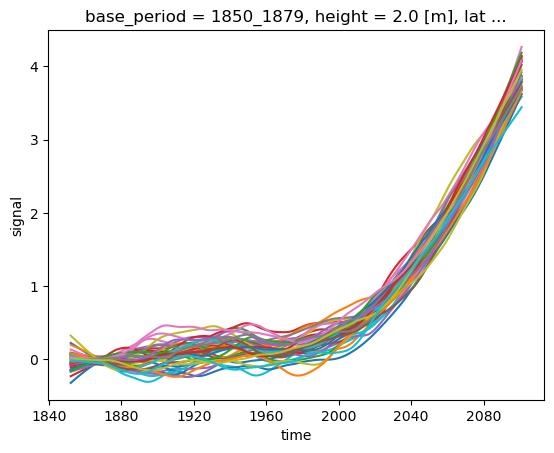

In [16]:
test_output.signal.isel(base_period=0).sel(lat=-39, lon=145, method='nearest').plot(
    hue='member', add_legend=False);

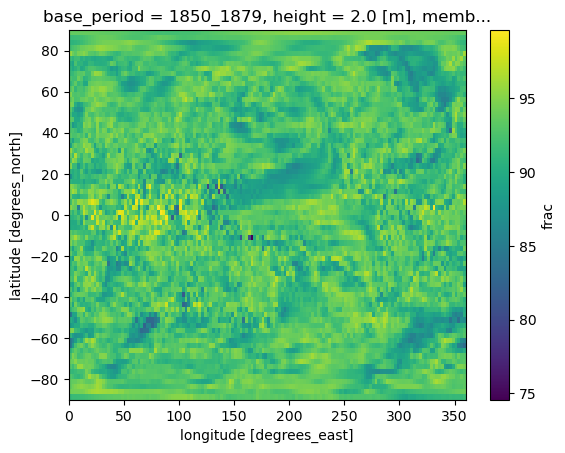

In [49]:
test_output.isel(base_period=0, member=0, time=10).frac.plot()

In [ ]:
# out_ds_2 = out_ds.copy(deep=True)

In [ ]:
# Pad new out_ds to match max_time_len
# out_ds_2 = out_ds_2.reindex(time=data_raw_ds.time, fill_value=np.nan)

In [ ]:
# Now append safely
# out_ds_2.to_zarr(SAVE_NAME, mode='a', append_dim='base_period')

In [ ]:
# base_period_ds = xr.concat(base_period_stor, dim='base_period')

In [ ]:
out_ds.sn.isel(member=0, lat=0, lon=0).plot(hue='base_period', add_legend=False);
# out_ds_2.sn.isel(member=0, lat=0, lon=0).plot(hue='base_period', add_legend=False);

In [ ]:
# base_period_ds.to_zarr(SAVE_NAME, mode='w')

In [ ]:
# def fga(data_ds, base_period_ds, data_ds_window):
#     # The x-values for the KDE are based upon the max and min
#     data_max = data_ds.max().persist().values.item()
#     data_min = data_ds.min().persist().values.item()
#     num_points = 1000
#     x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)
    
    
#     kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)
    
#     base_period_kde = xr.apply_ufunc(
#         toe_calc.create_kde_x_exists,
#         base_period_ds,
#         input_core_dims=[['time'], ],
#         output_core_dims=[['x']],
#         kwargs={'x': x, **kde_kwargs},
#         vectorize=True,
#         dask='parallelized',
#         output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
#         output_dtypes=float
#     ).persist()
#     wait(base_period_kde);
    
#     frac_geom_ds = xr.apply_ufunc(
#         toe_calc.fractional_geometric_area_optimized,
#         data_ds_window,
#         base_period_kde,
#         input_core_dims=[['window_dim'], ['x']],
#         exclude_dims={'window_dim'},
#         kwargs={'x': x, 'method_kwargs':kde_kwargs},
#         vectorize=True,
#         dask='parallelized',
#         output_dtypes=float
#     ).compute()
#     # wait(frac_geom_ds2)
    
#     x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
#     frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}

#     frac_geom_ds.name = 'frac'
    
#     return frac_geom_ds

In [ ]:
# def ks(data_ds_window, base_period_window_ds):
#     # The arguements needed for all of the calculations
#     rolling_window_kwargs = dict(
#         input_core_dims=[['window_dim'], ['window_dim']],
#         exclude_dims={'window_dim'},
#         vectorize=True,
#         dask='parallelized')
    
#     ks_ds = xr.apply_ufunc(
#             toe_calc.return_ks_pvalue,
#             data_ds_window,
#             base_period_window_ds,
#         **rolling_window_kwargs
#         ).compute()

#     ks_ds.name = 'ks'
#     return ks_ds

In [ ]:
# def sn_ratio(data_ds, base_period_ds, base_period):

#     # Resetting the anomlies to 1850
#     data_anom_ds = data_ds - base_period_ds.mean(dim='time')
#     base_period_anom_ds = base_period_ds - base_period_ds.mean(dim='time')
    
#     ds_signal_lowess = xr.apply_ufunc(
#         my_stats.apply_lowess, 
#         data_anom_ds.chunk({'time':-1, 'lat':10}), 
#         input_core_dims=[['time']],
#         output_core_dims=[['time']],
#         vectorize=True, 
#         kwargs = dict(window=41),
#         dask='parallelized',
#         output_dtypes=[float]
#     ).compute()
    
#     # Noise series is detrended data
#     ds_noise_series_lowess = (data_anom_ds - ds_signal_lowess).compute()
    
#     ds_noise_lowess_base_period = ds_noise_series_lowess.sel(
#         time=slice(str(base_period.start), str(base_period.end))).std(dim='time')
        
#     # S/N 
#     ds_sn_lowess_base_period = ds_signal_lowess/ds_noise_lowess_base_period
#     ds_sn_lowess_base_period.name = 'sn'

#     return ds_sn_lowess_base_period